In [252]:
import os
import requests
import json
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
#from MCForecastTools import MCSimulation
import numpy as np
%matplotlib inline
import hvplot.pandas
from decouple import config
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
from finta import TA

#API_USERNAME = config('USER')
#API_KEY = config('KEY')

In [253]:
load_dotenv()

True

In [254]:

alpaca_api_key = "PKIBBGDA5BNNNYX4NJ3D"
print("alpaca_api_key   ",type(alpaca_api_key))

alpaca_secret_key = "kZqEe7awHinSoXMNZHfsxpIwq6g8KGElaRtxIeeO"
print("alpaca_secret_key",type(alpaca_secret_key))

alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

alpaca_api_key    <class 'str'>
alpaca_secret_key <class 'str'>


,open,high,low,close,volume
timestamp,,,,,
2021-01-04 05:00:00+00:00,133.56,133.6116,126.760,129.41,143302687
2021-01-05 05:00:00+00:00,128.98,131.7400,128.430,131.01,97667342
2021-01-06 05:00:00+00:00,127.53,131.0499,126.382,126.60,155104120
2021-01-07 05:00:00+00:00,128.38,131.6300,127.860,130.92,109581117
2021-01-08 05:00:00+00:00,132.50,132.6300,130.230,132.05,105158675
...,...,...,...,...,...
2022-04-01 04:00:00+00:00,174.05,174.8800,171.940,174.31,78565894
2022-04-04 04:00:00+00:00,174.62,178.4900,174.440,178.44,76466048
2022-04-05 04:00:00+00:00,177.55,178.3000,174.415,175.06,73280511


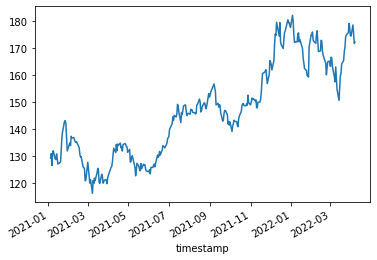

In [255]:

from alpaca_trade_api.rest import REST, TimeFrame
# Review the DataFrame
AAPL_df.head()

AAPL_df=alpaca.get_bars("AAPL", TimeFrame.Day, "2021-01-02", "2022-04-07", adjustment='raw').df
#AAPL_df_portfolio.dropna()

# Review the DataFrame
AAPL_df.head(10)
AAPL_df
AAPL_df["close"].plot()
#AAPL_df=pd.DataFrame(close, index=pd.DatetimeIndex)

#Maybe keep trade_count and vwap or drop
#AAPL_df=AAPL_df.drop(columns=["open","high","low","volume","trade_count","vwap"])
AAPL_df=AAPL_df.drop(columns=["trade_count","vwap"])
AAPL_df

Make X and Y Data Sets

In [327]:
AAPL_df['actual returns'] = AAPL_df['close'].pct_change()
AAPL_df = AAPL_df.dropna()

AAPL_df.head()

,open,high,low,close,volume,trade_type,cost/proceeds,accumulated_shares,actual returns
timestamp,,,,,,,,,
2021-01-06 05:00:00+00:00,127.53,131.0499,126.382,126.60,155104120,buy,-126.60,2.0,-0.033662
2021-01-07 05:00:00+00:00,128.38,131.6300,127.860,130.92,109581117,sell,261.84,0.0,0.034123
2021-01-11 05:00:00+00:00,129.00,130.1700,128.500,128.98,100647832,buy,-128.98,1.0,-0.023249
2021-01-20 05:00:00+00:00,128.62,132.4900,128.550,132.03,104326068,sell,132.03,0.0,0.032856
2021-01-21 05:00:00+00:00,133.83,139.6700,133.590,136.87,120531655,sell,0.00,0.0,0.036658


In [256]:
import hvplot.pandas
AAPL_df.hvplot.line()

:NdOverlay   [Variable]
   :Curve   [timestamp]   (value)

In [257]:
AAPL_df["trade_type"]=np.nan

In [258]:
previous_price=0

In [259]:
for index,row in AAPL_df.iterrows():
    if previous_price==0:
        AAPL_df.loc[index,"trade_type"]="buy"
        
    elif row["close"] < previous_price:
            AAPL_df.loc[index,"trade_type"]="buy"
    

    elif row["close"] > (1.005*previous_price):
            AAPL_df.loc[index,"trade_type"]="sell"
    else:
         AAPL_df.loc[index, "trade_type"] = "hold"
            
previous_price=row["close"]

if index == AAPL_df.index[-1]:
    AAPL_df.loc[index, "trade_type"] = "sell"

AAPL_df.head(15)
            
        

,open,high,low,close,volume,trade_type
timestamp,,,,,,
2021-01-04 05:00:00+00:00,133.56,133.6116,126.760,129.41,143302687,buy
2021-01-05 05:00:00+00:00,128.98,131.7400,128.430,131.01,97667342,buy
2021-01-06 05:00:00+00:00,127.53,131.0499,126.382,126.60,155104120,buy
2021-01-07 05:00:00+00:00,128.38,131.6300,127.860,130.92,109581117,buy
2021-01-08 05:00:00+00:00,132.50,132.6300,130.230,132.05,105158675,buy
2021-01-11 05:00:00+00:00,129.00,130.1700,128.500,128.98,100647832,buy
2021-01-12 05:00:00+00:00,128.48,129.6900,126.860,128.80,91984091,buy
2021-01-13 05:00:00+00:00,128.62,131.4500,128.490,130.89,88643360,buy
2021-01-14 05:00:00+00:00,130.76,131.0000,128.760,128.91,90126320,buy


In [260]:
AAPL_df["cost/proceeds"]=np.nan
share_size = 1
accumulated_shares = 0


In [261]:
for index, row in AAPL_df.iterrows():

    # buy if the previous_price is 0, in other words, buy on the first day
    if previous_price == 0:
        AAPL_df.loc[index, "trade_type"] = "buy"

        # calculate the cost of the trade by multiplying the current day's price
        # by the share_size, or number of shares purchased
        AAPL_df.loc[index, "cost/proceeds"] = -(row["close"] * share_size)

        # add the number of shares purchased to the accumulated shares
        accumulated_shares += share_size

    # buy if the current day's price is less than the previous day's price
    elif row["close"] < previous_price:
        AAPL_df.loc[index, "trade_type"] = "buy"

        # calculate the cost of the trade by multiplying the current day's price
        # by the share_size, or number of shares purchased
        AAPL_df.loc[index, "cost/proceeds"] = -(row["close"] * share_size)

        # add the number of shares purchased to the accumulated shares
        accumulated_shares += share_size
    elif row["close"] > (1.005*previous_price):
        AAPL_df.loc[index, "trade_type"] = "sell"

In [262]:
if index == AAPL_df.index[-1]:
    AAPL_df.loc[index, "trade_type"] = "sell"

    # calculate the proceeds by multiplying the last day's price by the accumulated shares
   # amd_df.loc[index, "cost/proceeds"] = row["close"] * accumulated_shares

In [263]:
#Initialize trade_type column to track buys and sells
AAPL_df["trade_type"] = np.nan

# Initialize a cost/proceeds column for recording trade metrics
AAPL_df["cost/proceeds"] = np.nan
AAPL_df["accumulated_shares"] = np.nan
# Initialize share size and accumulated shares
share_size = 1
accumulated_shares = 0

# Initialize variable to hold previous price
previous_price = 0

# Loop through the Pandas DataFrame and initiate a trade at each iteration
for index, row in AAPL_df.iterrows():

    # buy if the previous_price is 0, in other words, buy on the first day
    if previous_price == 0:
        AAPL_df.loc[index, "trade_type"] = "buy"

        # calculate the cost of the trade by multiplying the current day's price
        # by the share_size, or number of shares purchased
        AAPL_df.loc[index, "cost/proceeds"] = -(row["close"] * share_size)

        # add the number of shares purchased to the accumulated shares
        accumulated_shares += share_size
        AAPL_df.loc[index, "accumulated_shares"] = accumulated_shares
    # buy if the current day's price is less than the previous day's price
    elif row["close"] < 0.98*previous_price:
        AAPL_df.loc[index, "trade_type"] = "buy"

        # calculate the cost of the trade by multiplying the current day's price
        # by the share_size, or number of shares purchased
        AAPL_df.loc[index, "cost/proceeds"] = -(row["close"] * share_size)

        # add the number of shares purchased to the accumulated shares
        accumulated_shares += share_size
        AAPL_df.loc[index, "accumulated_shares"] = accumulated_shares
    # hold if the current day's price is greater than the previous day's price
    elif row["close"] > 1.02*previous_price:
        AAPL_df.loc[index, "trade_type"] = "sell"
        AAPL_df.loc[index, "cost/proceeds"] = (row["close"] * accumulated_shares)
        accumulated_shares=0
        AAPL_df.loc[index, "accumulated_shares"] = accumulated_shares
        
    # hold if the current day's price is equal to the previous day's price
    else:
        AAPL_df.loc[index, "trade_type"] = "hold"
        AAPL_df.loc[index, "accumulated_shares"] = accumulated_shares
    # update the previous_price to the current row's price
    previous_price = row["close"]

    # if the index is the last index of the DataFrame, sell
    if index == AAPL_df.index[-1]:
        AAPL_df.loc[index, "trade_type"] = "sell"

        # calculate the proceeds by multiplying the last day's price by the accumulated shares
        AAPL_df.loc[index, "cost/proceeds"] = row["close"] * accumulated_shares
        AAPL_df.loc[index, "accumulated_shares"] = accumulated_shares
# Review the DataFrame
AAPL_df


,open,high,low,close,volume,trade_type,cost/proceeds,accumulated_shares
timestamp,,,,,,,,
2021-01-04 05:00:00+00:00,133.56,133.6116,126.760,129.41,143302687,buy,-129.41,1.0
2021-01-05 05:00:00+00:00,128.98,131.7400,128.430,131.01,97667342,hold,NaN,1.0
2021-01-06 05:00:00+00:00,127.53,131.0499,126.382,126.60,155104120,buy,-126.60,2.0
2021-01-07 05:00:00+00:00,128.38,131.6300,127.860,130.92,109581117,sell,261.84,0.0
2021-01-08 05:00:00+00:00,132.50,132.6300,130.230,132.05,105158675,hold,NaN,0.0
...,...,...,...,...,...,...,...,...
2022-04-01 04:00:00+00:00,174.05,174.8800,171.940,174.31,78565894,hold,NaN,0.0
2022-04-04 04:00:00+00:00,174.62,178.4900,174.440,178.44,76466048,sell,0.00,0.0
2022-04-05 04:00:00+00:00,177.55,178.3000,174.415,175.06,73280511,hold,NaN,0.0


In [264]:
total_profit_loss = round(AAPL_df["cost/proceeds"].sum(),2)
print(f"The total profit/loss of the trading strategy is ${total_profit_loss}.")

The total profit/loss of the trading strategy is $71.84.


In [265]:
invested_capital = 0

# Calculate the invested capital by adding the cost of all buy trades
for index, row in AAPL_df.iterrows():
    if row["trade_type"] == "buy":
        invested_capital = invested_capital + row["cost/proceeds"]


# Calculate the return on investment (ROI)
roi = round((total_profit_loss / -(invested_capital)) * 100, 2)

# Print the ROI
print(f"The trading algorithm resulted in a return on investment of {roi}%")

The trading algorithm resulted in a return on investment of 1.51%


In [266]:
signals_df = AAPL_df.loc[:,["close"]]

short_window = 50
long_window = 100

signals_df['SMA50'] = signals_df['close'].rolling(window=short_window).mean()
signals_df['SMA100'] = signals_df['close'].rolling(window=long_window).mean()
signals_df['Signal'] = 0.0
signals_df

,close,SMA50,SMA100,Signal
timestamp,,,,
2021-01-04 05:00:00+00:00,129.41,NaN,NaN,0.0
2021-01-05 05:00:00+00:00,131.01,NaN,NaN,0.0
2021-01-06 05:00:00+00:00,126.60,NaN,NaN,0.0
2021-01-07 05:00:00+00:00,130.92,NaN,NaN,0.0
2021-01-08 05:00:00+00:00,132.05,NaN,NaN,0.0
...,...,...,...,...
2022-04-01 04:00:00+00:00,174.31,167.0210,167.54745,0.0
2022-04-04 04:00:00+00:00,178.44,167.3416,167.82375,0.0
2022-04-05 04:00:00+00:00,175.06,167.6104,168.09515,0.0


In [267]:
signals_df['Signal'][short_window:] = np.where(
    signals_df['SMA50'][short_window:] > signals_df['SMA100'][short_window:], 1.0, 0.0
)
signals_df['Entry/Exit'] = signals_df['Signal'].diff()


In [268]:
exit = signals_df[signals_df['Entry/Exit'] == -1.0]['close'].hvplot.scatter(
    color='yellow',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)
entry = signals_df[signals_df['Entry/Exit'] == 1.0]['close'].hvplot.scatter(
    color='purple',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = signals_df[['close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize moving averages
moving_avgs = signals_df[['SMA50', 'SMA100']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Create the overlay plot
entry_exit_plot = security_close * moving_avgs * entry * exit

# Show the plot
entry_exit_plot.opts(
    title="Apple - SMA50, SMA100, Entry and Exit Points"
)

:Overlay
   .Curve.I          :Curve   [timestamp]   (close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [timestamp]   (value)
   .Scatter.Close.I  :Scatter   [timestamp]   (close)
   .Scatter.Close.II :Scatter   [timestamp]   (close)

In [269]:
AAPL_bt_df=alpaca.get_bars("AAPL", TimeFrame.Day, "2016-01-02", "2017-04-07", adjustment='raw').df


#AAPL_bt_df=AAPL_bt_df.drop(columns=["open","high","low","volume","trade_count","vwap"])
AAPL_bt_df

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2016-01-04 05:00:00+00:00,102.50,105.368,102.00,105.35,67611658,351450,104.048524
2016-01-05 05:00:00+00:00,105.70,105.850,102.41,102.71,55787192,321363,103.415766
2016-01-06 05:00:00+00:00,100.50,102.370,99.87,100.70,68340388,409162,100.852488
2016-01-07 05:00:00+00:00,98.71,100.130,96.43,96.45,81094357,462834,98.069324
2016-01-08 05:00:00+00:00,98.53,99.110,96.76,96.96,70797966,419804,97.923007
...,...,...,...,...,...,...,...
2017-04-03 04:00:00+00:00,143.67,144.120,143.05,143.70,19986074,125532,143.657786
2017-04-04 04:00:00+00:00,143.25,144.890,143.17,144.77,19944851,123796,144.275936
2017-04-05 04:00:00+00:00,144.64,145.460,143.81,144.02,27724102,169568,144.784955


In [270]:
AAPL_df= AAPL_df.rename(columns=str.lower)
AAPL_df

,open,high,low,close,volume,trade_type,cost/proceeds,accumulated_shares
timestamp,,,,,,,,
2021-01-04 05:00:00+00:00,133.56,133.6116,126.760,129.41,143302687,buy,-129.41,1.0
2021-01-05 05:00:00+00:00,128.98,131.7400,128.430,131.01,97667342,hold,NaN,1.0
2021-01-06 05:00:00+00:00,127.53,131.0499,126.382,126.60,155104120,buy,-126.60,2.0
2021-01-07 05:00:00+00:00,128.38,131.6300,127.860,130.92,109581117,sell,261.84,0.0
2021-01-08 05:00:00+00:00,132.50,132.6300,130.230,132.05,105158675,hold,NaN,0.0
...,...,...,...,...,...,...,...,...
2022-04-01 04:00:00+00:00,174.05,174.8800,171.940,174.31,78565894,hold,NaN,0.0
2022-04-04 04:00:00+00:00,174.62,178.4900,174.440,178.44,76466048,sell,0.00,0.0
2022-04-05 04:00:00+00:00,177.55,178.3000,174.415,175.06,73280511,hold,NaN,0.0


In [271]:
df = pd.DataFrame()

In [272]:

# Create a function to find the optimal components for the trading algorithm
# Filter the date index and close columns
def trading_algo(short_window_input, long_window_input, training_period_input):
    signals_df = AAPL_df.loc[:, ["close"]]

    # Use the pct_change function to generate  returns from close prices
    signals_df["Actual Returns"] = signals_df["close"].pct_change()

    # Drop all NaN values from the DataFrame
    signals_df = signals_df.dropna()


    short_window = short_window_input
    long_window =long_window_input

    # Generate the fast and slow simple moving averages (4 and 100 days, respectively)
    signals_df['SMA_Fast'] = signals_df['close'].rolling(window=short_window).mean()
    signals_df['SMA_Slow'] = signals_df['close'].rolling(window=long_window).mean()

    signals_df = signals_df.dropna()


    # Initialize the new Signal column
    signals_df['Signal'] = 0.0

    # When Actual Returns are greater than or equal to 0, generate signal to buy stock long
    signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

    # When Actual Returns are less than 0, generate signal to sell stock short
    signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = 0


    # Calculate the strategy returns and add them to the signals_df DataFrame
    signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

    # Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
    X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

    # Create the target set selecting the Signal column and assiging it to y
    y = signals_df['Signal']

    # Select the start of the training period
    training_begin = X.index.min()

    # Select the ending period for the training data with an offset of 3 months
    training_end = X.index.min() + DateOffset(months=training_period_input)


    # Generate the X_train and y_train DataFrames
    X_train = X.loc[training_begin:training_end]
    y_train = y.loc[training_begin:training_end]


    # Generate the X_test and y_test DataFrames
    X_test = X.loc[training_end+DateOffset(hours=1):]
    y_test = y.loc[training_end+DateOffset(hours=1):]


    # Scale the features DataFrames

    # Create a StandardScaler instance
    scaler = StandardScaler()

    # Apply the scaler model to fit the X-train data
    X_scaler = scaler.fit(X_train)

    # Transform the X_train and X_test DataFrames using the X_scaler
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    X_test_scaled

    # From SVM, instantiate SVC classifier model instance
    svm_model = svm.SVC()

    # Fit the model to the data using the training data
    svm_model = svm_model.fit(X_train_scaled, y_train)

    # Use the testing data to make the model predictions
    svm_pred = svm_model.predict(X_test_scaled)


    # Use a classification report to evaluate the model using the predictions and testing data
    svm_testing_report = classification_report(y_test, svm_pred)


    # Create a new empty predictions DataFrame.

    # Create a predictions DataFrame
    predictions_df = pd.DataFrame(index=X_test.index)

    # Add the SVM model predictions to the DataFrame
    predictions_df['Predicted'] = svm_pred

    # Add the actual returns to the DataFrame
    predictions_df['Actual Returns'] = signals_df["Actual Returns"]

    # Add the strategy returns to the DataFrame
    predictions_df['Strategy Returns'] = signals_df["Actual Returns"] * predictions_df["Predicted"]


  
    # Create the column names for the dataframe to find the optimal components for the algorithm. The column names will be generated by the for loop
    df[f'{short_window}_{long_window}_{training_period}'] = (1+predictions_df["Strategy Returns"]).cumprod()
    # Plot the actual returns versus the strategy returns
    #(1+predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot(title= f"{short_window}, {long_window}, {training_period_input}")

## Establish a Baseline Performance using SVC Classifier model

In [273]:
# Create lists for our function to iterate through
short_window_list = [5,10,15,20,30,50]
long_window_list = [60,80,100,150,200]
training_period_list= [1,2,3,4,5,6,7,8]

## Part 1: Backtesting a Moving Average Crossover in Python with pandas

In [279]:
# ma_cross.py

import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#from pandas.io.data import DataReader
import pandas_datareader.data as web
from backtesting import Backtest, Strategy
#from backtesting import Strategy, Portfolio
from backtesting import Backtest, Strategy
from backtesting.lib import crossover



In [280]:
#Create a for loop to find the optimal components for our algorithm
for short_window in short_window_list:
    for long_window in long_window_list:
        for training_period in training_period_list:
            trading_algo(short_window, long_window, training_period)
            #trading_algo=short_window_list: list[int], long_window_list: list[int], training_period_list: list[int]

/Users/kalyana/opt/anaconda3/envs/dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kalyana/opt/anaconda3/envs/dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kalyana/opt/anaconda3/envs/dev/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

ValueError: Found array with 0 sample(s) (shape=(0, 2)) while a minimum of 1 is required by StandardScaler.

In [289]:
#from backtesting import Backtest, Strategy
#from backtesting.lib import crossover

#from backtesting.test import Backtest, Strategy


class AAPL_Cross(Strategy):
    def init(self):
        price = self.data.Close
        self.ma1 = self.I(AAPL, price, 10)
        self.ma2 = self.I(AAPL, price, 20)

    def next(self):
        if crossover(self.ma1, self.ma2):
            self.buy()
        elif crossover(self.ma2, self.ma1):
            self.sell()


bt = Backtest(AAPL_Cross, commission=.002, Strategy
              exclusive_orders=True)
stats = bt.run()
bt.plot()

SyntaxError: invalid syntax (2427307957.py, line 21)

In [290]:
#tells us optimal combo for windows and training period

optimal_combo = df.columns[(df==df.iloc[-1].max()).iloc[-1]]
optimal_combo = optimal_combo[0]
print (optimal_combo)


5_60_1


In [291]:
#Need to parse out the 3 params. Isaac to work on this
split_string = optimal_combo.split("_",2)
short_win = int(split_string[0])
long_win = int(split_string[1])
train_period = int(split_string[2])
print(short_win, long_win, train_period)

5 60 1


In [292]:

# Generate the fast and slow simple moving averages
# Filter the date index and adj close columns
signals_df = AAPL_df.loc[:, ["close"]]

# Use the pct_change function to generate  returns from close prices
signals_df["Actual Returns"] = signals_df["close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()


signals_df['SMA_Fast'] = signals_df['close'].rolling(window=short_win).mean()
signals_df['SMA_Slow'] = signals_df['close'].rolling(window=long_win).mean()
bollinger_df = TA.BBANDS(AAPL_df)
#macd_df = TA.MACD(AAPL_df)

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(bollinger_df)
#display(macd_df)

,close,Actual Returns,SMA_Fast,SMA_Slow
timestamp,,,,
2021-03-31 04:00:00+00:00,122.15,0.018766,121.048,128.340417
2021-04-01 04:00:00+00:00,123.00,0.006959,121.530,128.206917
2021-04-05 04:00:00+00:00,125.90,0.023577,122.468,128.195250
2021-04-06 04:00:00+00:00,126.21,0.002462,123.432,128.116750
2021-04-07 04:00:00+00:00,127.90,0.013390,125.032,128.047583


,BB_UPPER,BB_MIDDLE,BB_LOWER
timestamp,,,
2021-01-04 05:00:00+00:00,NaN,NaN,NaN
2021-01-05 05:00:00+00:00,NaN,NaN,NaN
2021-01-06 05:00:00+00:00,NaN,NaN,NaN
2021-01-07 05:00:00+00:00,NaN,NaN,NaN
2021-01-08 05:00:00+00:00,NaN,NaN,NaN
...,...,...,...
2022-04-01 04:00:00+00:00,183.329138,165.8645,148.399862
2022-04-04 04:00:00+00:00,184.859752,166.8215,148.783248
2022-04-05 04:00:00+00:00,185.531425,167.7025,149.873575


## Part 2: Create trading signals using short- and long-window SMA values based off SMA Optimizer function

In [293]:
signals_df = pd.concat([bollinger_df, signals_df], axis=1)

In [294]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = 0

signals_df['Entry/Exit'] = signals_df['Signal'].diff()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())
signals_df = signals_df.dropna()

,BB_UPPER,BB_MIDDLE,BB_LOWER,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Entry/Exit
timestamp,,,,,,,,,
2021-01-04 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2021-01-05 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2021-01-06 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2021-01-07 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2021-01-08 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


,BB_UPPER,BB_MIDDLE,BB_LOWER,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Entry/Exit
timestamp,,,,,,,,,
2022-04-01 04:00:00+00:00,183.329138,165.8645,148.399862,174.31,-0.001718,176.250,167.730333,0.0,0.0
2022-04-04 04:00:00+00:00,184.859752,166.8215,148.783248,178.44,0.023693,176.818,167.837667,1.0,1.0
2022-04-05 04:00:00+00:00,185.531425,167.7025,149.873575,175.06,-0.018942,176.038,167.885833,0.0,-1.0
2022-04-06 04:00:00+00:00,185.897140,168.1345,150.371860,171.59,-0.019822,174.802,167.875833,0.0,0.0
2022-04-07 04:00:00+00:00,186.062982,168.8155,151.568018,172.14,0.003205,174.308,167.826833,1.0,1.0


In [295]:
signals_df.count()

BB_UPPER          259
BB_MIDDLE         259
BB_LOWER          259
close             259
Actual Returns    259
SMA_Fast          259
SMA_Slow          259
Signal            259
Entry/Exit        259
dtype: int64

In [296]:
#signals_df = signals_df[signals_df.Signal !=0]
signals_df['Signal'].value_counts()

1.0    138
0.0    121
Name: Signal, dtype: int64

In [297]:
signals_df.dropna()

,BB_UPPER,BB_MIDDLE,BB_LOWER,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Entry/Exit
timestamp,,,,,,,,,
2021-03-31 04:00:00+00:00,125.460550,121.40325,117.345950,122.15,0.018766,121.048,128.340417,1.0,1.0
2021-04-01 04:00:00+00:00,125.617431,121.54675,117.476069,123.00,0.006959,121.530,128.206917,1.0,0.0
2021-04-05 04:00:00+00:00,126.281341,121.77075,117.260159,125.90,0.023577,122.468,128.195250,1.0,0.0
2021-04-06 04:00:00+00:00,126.423726,122.26325,118.102774,126.21,0.002462,123.432,128.116750,1.0,0.0
2021-04-07 04:00:00+00:00,127.422449,122.60400,117.785551,127.90,0.013390,125.032,128.047583,1.0,0.0
...,...,...,...,...,...,...,...,...,...
2022-04-01 04:00:00+00:00,183.329138,165.86450,148.399862,174.31,-0.001718,176.250,167.730333,0.0,0.0
2022-04-04 04:00:00+00:00,184.859752,166.82150,148.783248,178.44,0.023693,176.818,167.837667,1.0,1.0
2022-04-05 04:00:00+00:00,185.531425,167.70250,149.873575,175.06,-0.018942,176.038,167.885833,0.0,-1.0


In [298]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

# Review the DataFrame

display(signals_df.head())
display(signals_df.tail())


,BB_UPPER,BB_MIDDLE,BB_LOWER,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Entry/Exit,Strategy Returns
timestamp,,,,,,,,,,
2021-03-31 04:00:00+00:00,125.460550,121.40325,117.345950,122.15,0.018766,121.048,128.340417,1.0,1.0,NaN
2021-04-01 04:00:00+00:00,125.617431,121.54675,117.476069,123.00,0.006959,121.530,128.206917,1.0,0.0,0.006959
2021-04-05 04:00:00+00:00,126.281341,121.77075,117.260159,125.90,0.023577,122.468,128.195250,1.0,0.0,0.023577
2021-04-06 04:00:00+00:00,126.423726,122.26325,118.102774,126.21,0.002462,123.432,128.116750,1.0,0.0,0.002462
2021-04-07 04:00:00+00:00,127.422449,122.60400,117.785551,127.90,0.013390,125.032,128.047583,1.0,0.0,0.013390


,BB_UPPER,BB_MIDDLE,BB_LOWER,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Entry/Exit,Strategy Returns
timestamp,,,,,,,,,,
2022-04-01 04:00:00+00:00,183.329138,165.8645,148.399862,174.31,-0.001718,176.250,167.730333,0.0,0.0,-0.000000
2022-04-04 04:00:00+00:00,184.859752,166.8215,148.783248,178.44,0.023693,176.818,167.837667,1.0,1.0,0.000000
2022-04-05 04:00:00+00:00,185.531425,167.7025,149.873575,175.06,-0.018942,176.038,167.885833,0.0,-1.0,-0.018942
2022-04-06 04:00:00+00:00,185.897140,168.1345,150.371860,171.59,-0.019822,174.802,167.875833,0.0,0.0,-0.000000
2022-04-07 04:00:00+00:00,186.062982,168.8155,151.568018,172.14,0.003205,174.308,167.826833,1.0,1.0,0.000000


In [299]:
signals_df.dropna()
signals_df.head(10)

,BB_UPPER,BB_MIDDLE,BB_LOWER,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Entry/Exit,Strategy Returns
timestamp,,,,,,,,,,
2021-03-31 04:00:00+00:00,125.460550,121.40325,117.345950,122.1500,0.018766,121.04800,128.340417,1.0,1.0,NaN
2021-04-01 04:00:00+00:00,125.617431,121.54675,117.476069,123.0000,0.006959,121.53000,128.206917,1.0,0.0,0.006959
2021-04-05 04:00:00+00:00,126.281341,121.77075,117.260159,125.9000,0.023577,122.46800,128.195250,1.0,0.0,0.023577
2021-04-06 04:00:00+00:00,126.423726,122.26325,118.102774,126.2100,0.002462,123.43200,128.116750,1.0,0.0,0.002462
2021-04-07 04:00:00+00:00,127.422449,122.60400,117.785551,127.9000,0.013390,125.03200,128.047583,1.0,0.0,0.013390
2021-04-08 04:00:00+00:00,128.893448,123.12300,117.352552,130.3600,0.019234,126.67400,128.070583,1.0,0.0,0.019234
2021-04-09 04:00:00+00:00,130.903073,123.67475,116.446427,132.9950,0.020213,128.67300,128.140500,1.0,0.0,0.020213
2021-04-12 04:00:00+00:00,132.073207,124.19175,116.310293,131.3700,-0.012219,129.76700,128.148500,0.0,-1.0,-0.012219
2021-04-13 04:00:00+00:00,133.818273,124.71238,115.606487,134.4026,0.023084,131.40552,128.240043,1.0,1.0,0.000000


<AxesSubplot:xlabel='timestamp'>

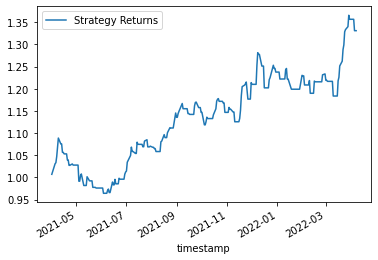

In [300]:
# Plot Strategy Returns to examine performance
(1 + signals_df[['Strategy Returns']]).cumprod().plot()

### Part 3: Split the data into training and testing datasets

In [301]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['SMA_Fast', 'SMA_Slow', "close", "Actual Returns","BB_UPPER", "BB_MIDDLE", "BB_LOWER"]].shift().dropna()

# Review the DataFrame
X

,SMA_Fast,SMA_Slow,close,Actual Returns,BB_UPPER,BB_MIDDLE,BB_LOWER
timestamp,,,,,,,
2021-04-01 04:00:00+00:00,121.048,128.340417,122.15,0.018766,125.460550,121.40325,117.345950
2021-04-05 04:00:00+00:00,121.530,128.206917,123.00,0.006959,125.617431,121.54675,117.476069
2021-04-06 04:00:00+00:00,122.468,128.195250,125.90,0.023577,126.281341,121.77075,117.260159
2021-04-07 04:00:00+00:00,123.432,128.116750,126.21,0.002462,126.423726,122.26325,118.102774
2021-04-08 04:00:00+00:00,125.032,128.047583,127.90,0.013390,127.422449,122.60400,117.785551
...,...,...,...,...,...,...,...
2022-04-01 04:00:00+00:00,176.332,167.739083,174.61,-0.017776,182.343335,165.30750,148.271665
2022-04-04 04:00:00+00:00,176.250,167.730333,174.31,-0.001718,183.329138,165.86450,148.399862
2022-04-05 04:00:00+00:00,176.818,167.837667,178.44,0.023693,184.859752,166.82150,148.783248


In [302]:
# Create the target set selecting the Signal column and assiging it to y
#signals_df = signals_df[signals_df.Signal !=0]
y = signals_df['Signal'] 

# Review the value counts
y.value_counts()

1.0    138
0.0    121
Name: Signal, dtype: int64

In [303]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2021-04-01 04:00:00+00:00


In [304]:
# Select the ending period for the training data with an offset of X months
training_end = X.index.min() + DateOffset(months=train_period)

# Display the training end date
print(training_end)

2021-05-01 04:00:00+00:00


In [305]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
y_train.count()
X_train.count()

SMA_Fast          21
SMA_Slow          21
close             21
Actual Returns    21
BB_UPPER          21
BB_MIDDLE         21
BB_LOWER          21
dtype: int64

In [306]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
#X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]
#y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
display(X_test.count())
X_test

SMA_Fast          237
SMA_Slow          237
close             237
Actual Returns    237
BB_UPPER          237
BB_MIDDLE         237
BB_LOWER          237
dtype: int64

,SMA_Fast,SMA_Slow,close,Actual Returns,BB_UPPER,BB_MIDDLE,BB_LOWER
timestamp,,,,,,,
2021-05-03 04:00:00+00:00,133.526,127.786293,131.46,-0.015133,137.720255,132.25563,126.791005
2021-05-04 04:00:00+00:00,133.090,127.705460,132.54,0.008215,137.160489,132.58763,128.014771
2021-05-05 04:00:00+00:00,131.782,127.556960,127.85,-0.035386,136.798194,132.66963,128.541066
2021-05-06 04:00:00+00:00,130.686,127.410127,128.10,0.001955,136.760241,132.67963,128.599019
2021-05-07 04:00:00+00:00,129.934,127.305293,129.72,0.012646,136.813970,132.64763,128.481290
...,...,...,...,...,...,...,...
2022-04-01 04:00:00+00:00,176.332,167.739083,174.61,-0.017776,182.343335,165.30750,148.271665
2022-04-04 04:00:00+00:00,176.250,167.730333,174.31,-0.001718,183.329138,165.86450,148.399862
2022-04-05 04:00:00+00:00,176.818,167.837667,178.44,0.023693,184.859752,166.82150,148.783248


In [307]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

#X_test_scaled[:2000]

In [308]:
len(X_train_scaled)

21

In [309]:
len(y_train)

21

In [310]:
# From SVM, represent as or by an instance SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

 #Review the model's predicted values
svm_pred[:100]
#svm_pred[:2000]

array([0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [311]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)
# Print the classification report

print(svm_testing_report)


              precision    recall  f1-score   support

         0.0       0.50      0.03      0.05       112
         1.0       0.53      0.98      0.69       125

    accuracy                           0.53       237
   macro avg       0.51      0.50      0.37       237
weighted avg       0.51      0.53      0.39       237



In [312]:
# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)
# Add the SVM model predictions to the DataFrame
predictions_df["predicted_signal"] = svm_pred
predictions_df

,predicted_signal
timestamp,
2021-05-03 04:00:00+00:00,0.0
2021-05-04 04:00:00+00:00,0.0
2021-05-05 04:00:00+00:00,1.0
2021-05-06 04:00:00+00:00,0.0
2021-05-07 04:00:00+00:00,1.0
...,...
2022-04-01 04:00:00+00:00,1.0
2022-04-04 04:00:00+00:00,1.0
2022-04-05 04:00:00+00:00,1.0


In [313]:

# Add the actual returns to the DataFrame
predictions_df["Actual Returns"] = signals_df["Actual Returns"]

# Add the strategy returns to the DataFrame
predictions_df["Strategy Returns"] = predictions_df["Actual Returns"] * predictions_df["predicted_signal"]
predictions_df["Entry/Exit"] = predictions_df["predicted_signal"].diff()
predictions_df["close"] = signals_df["close"]
predictions_df.tail(20)

# Review the DataFrame
display(predictions_df.head(10))
display(predictions_df.tail())


,predicted_signal,Actual Returns,Strategy Returns,Entry/Exit,close
timestamp,,,,,
2021-05-03 04:00:00+00:00,0.0,0.008215,0.000000,NaN,132.54
2021-05-04 04:00:00+00:00,0.0,-0.035386,-0.000000,0.0,127.85
2021-05-05 04:00:00+00:00,1.0,0.001955,0.001955,1.0,128.10
2021-05-06 04:00:00+00:00,0.0,0.012646,0.000000,-1.0,129.72
2021-05-07 04:00:00+00:00,1.0,0.003777,0.003777,1.0,130.21
2021-05-10 04:00:00+00:00,1.0,-0.025804,-0.025804,0.0,126.85
2021-05-11 04:00:00+00:00,1.0,-0.007410,-0.007410,0.0,125.91
2021-05-12 04:00:00+00:00,1.0,-0.024541,-0.024541,0.0,122.82
2021-05-13 04:00:00+00:00,1.0,0.017261,0.017261,0.0,124.94


,predicted_signal,Actual Returns,Strategy Returns,Entry/Exit,close
timestamp,,,,,
2022-04-01 04:00:00+00:00,1.0,-0.001718,-0.001718,0.0,174.31
2022-04-04 04:00:00+00:00,1.0,0.023693,0.023693,0.0,178.44
2022-04-05 04:00:00+00:00,1.0,-0.018942,-0.018942,0.0,175.06
2022-04-06 04:00:00+00:00,1.0,-0.019822,-0.019822,0.0,171.59
2022-04-07 04:00:00+00:00,1.0,0.003205,0.003205,0.0,172.14


# Part 7: We made cumulative return plot which shows actual returns versus strategy returns. We saved a PNG image of this plot. Now this will be designated as a baseline against which the effects of tuning the trading algorithm would be compared

<AxesSubplot:xlabel='timestamp'>

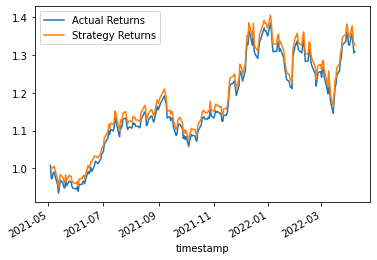

In [314]:
# Plot the actual returns versus the strategy returns
(1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot()

In [315]:
# Visualize entry positions relative to close price
entry = signals_df[signals_df['Entry/Exit'] == 1.0]['close'].hvplot.scatter(
    color='blue',
    marker='^',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize exit positions relative to close price
exit = signals_df[signals_df['Entry/Exit'] == -1.0]['close'].hvplot.scatter(
    color='green',
    marker='v',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize the close price for the investment
security_close = signals_df[['close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize the moving averages
moving_avgs = signals_df[['SMA_Fast', 'SMA_Slow']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400)

# Overlay the plots
entry_exit_plot = security_close * moving_avgs * entry * exit
entry_exit_plot.opts(
    title="Momentum Trading Algorithm"
)

:Overlay
   .Curve.I          :Curve   [timestamp]   (close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [timestamp]   (value)
   .Scatter.Close.I  :Scatter   [timestamp]   (close)
   .Scatter.Close.II :Scatter   [timestamp]   (close)

In [316]:
predictions_df

,predicted_signal,Actual Returns,Strategy Returns,Entry/Exit,close
timestamp,,,,,
2021-05-03 04:00:00+00:00,0.0,0.008215,0.000000,NaN,132.54
2021-05-04 04:00:00+00:00,0.0,-0.035386,-0.000000,0.0,127.85
2021-05-05 04:00:00+00:00,1.0,0.001955,0.001955,1.0,128.10
2021-05-06 04:00:00+00:00,0.0,0.012646,0.000000,-1.0,129.72
2021-05-07 04:00:00+00:00,1.0,0.003777,0.003777,1.0,130.21
...,...,...,...,...,...
2022-04-01 04:00:00+00:00,1.0,-0.001718,-0.001718,0.0,174.31
2022-04-04 04:00:00+00:00,1.0,0.023693,0.023693,0.0,178.44
2022-04-05 04:00:00+00:00,1.0,-0.018942,-0.018942,0.0,175.06


In [317]:
# Visualize entry positions relative to close price
entry = predictions_df[predictions_df['Entry/Exit'] == 1.0]['close'].hvplot.scatter(
    color='purple',
    marker='^',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize exit positions relative to close price
exit = predictions_df[predictions_df['Entry/Exit'] == -1.0]['close'].hvplot.scatter(
    color='orange',
    marker='v',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize the close price for the investment
security_close = predictions_df[['close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize the moving averages
moving_avgs = signals_df[['SMA_Fast', 'SMA_Slow', "BB_MIDDLE", "BB_UPPER", "BB_LOWER"]].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400)

# Overlay the plots
entry_exit_plot = security_close * moving_avgs * entry * exit
entry_exit_plot.opts(
    title="SVC ML Model Trading Algorithm"
)

:Overlay
   .Curve.I          :Curve   [timestamp]   (close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [timestamp]   (value)
   .Scatter.Close.I  :Scatter   [timestamp]   (close)
   .Scatter.Close.II :Scatter   [timestamp]   (close)

In [318]:
# Set the initial_capital to 100000
initial_capital = float(100000)
# Set the share_size to 500 
share_size = 500
# Create a column named "Position" by multiplying the share_size by the Signal
# Sell a position (-500 shares) when the dual moving average crossover Signal equals 1 (SMA50 is less than SMA100)
predictions_df["Position"] = share_size * predictions_df["predicted_signal"]

# Find the points in time where a 500 share position is bought or sold
predictions_df["Entry/Exit Position"] = predictions_df["Position"].diff()

# Create a Portfolio Holdings column by multiplying the Close price by the Position
predictions_df["Portfolio Holdings"] = predictions_df["close"] * predictions_df["Position"]

# To calculate Portfolio Cash, subtract the cumulative sum of the trade cost/proceeds from the initial_capital
# The trade cost proceeds are calculated by multiplying the Close price by Entry/Exit Position
predictions_df["Portfolio Cash"] = (
    initial_capital - (predictions_df["close"] * predictions_df["Entry/Exit Position"]).cumsum()
)

# Calculate the Portfolio Total value by adding Portfolio Cash and Portfolio Holdings 
predictions_df["Portfolio Total"] = predictions_df["Portfolio Cash"] + predictions_df["Portfolio Holdings"]

# Calculate the Portfolio Daily Returns based on the Portfolio Total
predictions_df["Portfolio Daily Returns"] = predictions_df["Portfolio Total"].pct_change()

# Calculate the Portfolio Cumulative Returns based on the Portfolio Daily Returns
predictions_df["Portfolio Cumulative Returns"] = (
    1 + predictions_df["Portfolio Daily Returns"]
).cumprod() - 1

# Review the DataFrame
display(predictions_df.head(4))
display(predictions_df.tail(4))

,predicted_signal,Actual Returns,Strategy Returns,Entry/Exit,close,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
timestamp,,,,,,,,,,,,
2021-05-03 04:00:00+00:00,0.0,0.008215,0.000000,NaN,132.54,0.0,NaN,0.0,NaN,NaN,NaN,NaN
2021-05-04 04:00:00+00:00,0.0,-0.035386,-0.000000,0.0,127.85,0.0,0.0,0.0,100000.0,100000.0,NaN,NaN
2021-05-05 04:00:00+00:00,1.0,0.001955,0.001955,1.0,128.10,500.0,500.0,64050.0,35950.0,100000.0,0.0000,0.0000
2021-05-06 04:00:00+00:00,0.0,0.012646,0.000000,-1.0,129.72,0.0,-500.0,0.0,100810.0,100810.0,0.0081,0.0081


,predicted_signal,Actual Returns,Strategy Returns,Entry/Exit,close,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
timestamp,,,,,,,,,,,,
2022-04-04 04:00:00+00:00,1.0,0.023693,0.023693,0.0,178.44,500.0,0.0,89220.0,35070.0,124290.0,0.016895,0.24290
2022-04-05 04:00:00+00:00,1.0,-0.018942,-0.018942,0.0,175.06,500.0,0.0,87530.0,35070.0,122600.0,-0.013597,0.22600
2022-04-06 04:00:00+00:00,1.0,-0.019822,-0.019822,0.0,171.59,500.0,0.0,85795.0,35070.0,120865.0,-0.014152,0.20865
2022-04-07 04:00:00+00:00,1.0,0.003205,0.003205,0.0,172.14,500.0,0.0,86070.0,35070.0,121140.0,0.002275,0.21140


In [319]:
# Visualize the entry positions relative to the Portfolio Total
entry = predictions_df[predictions_df["Entry/Exit"] == 1.0]["Portfolio Total"].hvplot.scatter(
    color='purple',
    marker='^',
    legend=False, 
    ylabel="Total Portfolio Value", 
    width=1000, 
    height=400
)

# Visualize the exit positions relative to the Portfolio Total
exit = predictions_df[predictions_df["Entry/Exit"] == -1.0]["Portfolio Total"].hvplot.scatter(
    color='orange',
    marker='v',
    legend=False, 
    ylabel="Total Portfolio Value", 
    width=1000, 
    height=400
)

# Visualize Portfolio Total for the investment
total_portfolio_value = predictions_df[["Portfolio Total"]].hvplot(
    line_color="lightgray", 
    ylabel="Total Portfolio Value", 
    width=1000, 
    height=400
)

# Overlay the entry, exit and total_portfolio_value plots
portfolio_entry_exit_plot = total_portfolio_value * entry * exit
portfolio_entry_exit_plot.opts(
    title="Algorithm - Total Portfolio Value",
    yformatter='%.0f'
)

:Overlay
   .Curve.I                    :Curve   [timestamp]   (Portfolio Total)
   .Scatter.Portfolio_Total.I  :Scatter   [timestamp]   (Portfolio Total)
   .Scatter.Portfolio_Total.II :Scatter   [timestamp]   (Portfolio Total)

In [320]:
# Import a new classifier from SKLearn
from sklearn.linear_model import LogisticRegression

# Initiate the model instance
logistic_regression_model = LogisticRegression()


In [321]:
# Fit the model using the training data
lr_model = logistic_regression_model.fit(X_train_scaled, y_train)

# Use the testing dataset to generate the predictions for the new model
lr_pred = logistic_regression_model.predict(X_test_scaled)

# Review the model's predicted values
lr_pred[:10]


array([0., 0., 1., 0., 0., 0., 1., 1., 1., 1.])

In [322]:
# Use a classification report to evaluate the model using the predictions and testing data
lr_testing_report = classification_report(y_test, lr_pred)

# Print the classification report
print(lr_testing_report)


              precision    recall  f1-score   support

         0.0       0.47      0.88      0.62       112
         1.0       0.54      0.12      0.20       125

    accuracy                           0.48       237
   macro avg       0.50      0.50      0.41       237
weighted avg       0.51      0.48      0.39       237



In [323]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
predictions_lr_df = pd.DataFrame(index=X_test.index)
# Add the SVM model predictions to the DataFrame
predictions_lr_df["predicted_signal"] = lr_pred

# Add the actual returns to the DataFrame
predictions_lr_df["Actual Returns"] = signals_df["Actual Returns"]

# Add the strategy returns to the DataFrame
predictions_lr_df["Strategy Returns LR"] = predictions_lr_df["Actual Returns"] * predictions_lr_df["predicted_signal"]
predictions_lr_df["Entry/Exit"] = predictions_lr_df["predicted_signal"].diff()
predictions_lr_df["Adj Close"] = signals_df["close"]
predictions_lr_df.tail(20)

# Review the DataFrame
display(predictions_lr_df.head())
display(predictions_lr_df.tail())

,predicted_signal,Actual Returns,Strategy Returns LR,Entry/Exit,Adj Close
timestamp,,,,,
2021-05-03 04:00:00+00:00,0.0,0.008215,0.000000,NaN,132.54
2021-05-04 04:00:00+00:00,0.0,-0.035386,-0.000000,0.0,127.85
2021-05-05 04:00:00+00:00,1.0,0.001955,0.001955,1.0,128.10
2021-05-06 04:00:00+00:00,0.0,0.012646,0.000000,-1.0,129.72
2021-05-07 04:00:00+00:00,0.0,0.003777,0.000000,0.0,130.21


,predicted_signal,Actual Returns,Strategy Returns LR,Entry/Exit,Adj Close
timestamp,,,,,
2022-04-01 04:00:00+00:00,0.0,-0.001718,-0.0,0.0,174.31
2022-04-04 04:00:00+00:00,0.0,0.023693,0.0,0.0,178.44
2022-04-05 04:00:00+00:00,0.0,-0.018942,-0.0,0.0,175.06
2022-04-06 04:00:00+00:00,0.0,-0.019822,-0.0,0.0,171.59
2022-04-07 04:00:00+00:00,0.0,0.003205,0.0,0.0,172.14


<AxesSubplot:xlabel='timestamp'>

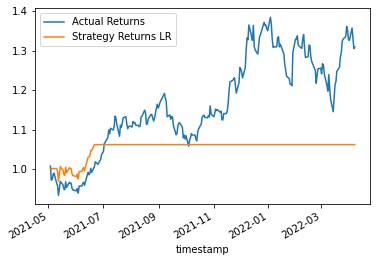

In [324]:
# Plot the actual returns versus the strategy returns
(1 + predictions_lr_df[["Actual Returns", "Strategy Returns LR"]]).cumprod().plot()
#Second Plot logistic regression 6 months training data and new SMAs

In [325]:
 #Set the initial_capital to 100000
initial_capital = float(100000)
# Set the share_size to 500 
share_size = 500
# Create a column named "Position" by multiplying the share_size by the Signal
# Sell a position (-500 shares) when the dual moving average crossover Signal equals 1 (SMA50 is less than SMA100)
predictions_lr_df["Position"] = share_size * predictions_lr_df["predicted_signal"]

# Find the points in time where a 500 share position is bought or sold
predictions_lr_df["Entry/Exit Position"] = predictions_lr_df["Position"].diff()

# Create a Portfolio Holdings column by multiplying the Close price by the Position
predictions_lr_df["Portfolio Holdings"] = predictions_lr_df["Adj Close"] * predictions_lr_df["Position"]

# To calculate Portfolio Cash, subtract the cumulative sum of the trade cost/proceeds from the initial_capital
# The trade cost proceeds are calculated by multiplying the Close price by Entry/Exit Position
predictions_lr_df["Portfolio Cash"] = (
    initial_capital - (predictions_lr_df["Adj Close"] * predictions_lr_df["Entry/Exit Position"]).cumsum()
)

# Calculate the Portfolio Total value by adding Portfolio Cash and Portfolio Holdings 
predictions_lr_df["Portfolio Total"] = predictions_lr_df["Portfolio Cash"] + predictions_lr_df["Portfolio Holdings"]

# Calculate the Portfolio Daily Returns based on the Portfolio Total
predictions_lr_df["Portfolio Daily Returns"] = predictions_lr_df["Portfolio Total"].pct_change()

# Calculate the Portfolio Cumulative Returns based on the Portfolio Daily Returns
predictions_lr_df["Portfolio Cumulative Returns"] = (
    1 + predictions_lr_df["Portfolio Daily Returns"]
).cumprod() - 1

# Review the DataFrame
predictions_lr_df.tail()

,predicted_signal,Actual Returns,Strategy Returns LR,Entry/Exit,Adj Close,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
timestamp,,,,,,,,,,,,
2022-04-01 04:00:00+00:00,0.0,-0.001718,-0.0,0.0,174.31,0.0,0.0,0.0,103670.0,103670.0,0.0,0.0367
2022-04-04 04:00:00+00:00,0.0,0.023693,0.0,0.0,178.44,0.0,0.0,0.0,103670.0,103670.0,0.0,0.0367
2022-04-05 04:00:00+00:00,0.0,-0.018942,-0.0,0.0,175.06,0.0,0.0,0.0,103670.0,103670.0,0.0,0.0367
2022-04-06 04:00:00+00:00,0.0,-0.019822,-0.0,0.0,171.59,0.0,0.0,0.0,103670.0,103670.0,0.0,0.0367
2022-04-07 04:00:00+00:00,0.0,0.003205,0.0,0.0,172.14,0.0,0.0,0.0,103670.0,103670.0,0.0,0.0367


In [326]:
# Visualize the entry positions relative to the Portfolio Total
entry = predictions_lr_df[predictions_lr_df["Entry/Exit"] == 1.0]["Portfolio Total"].hvplot.scatter(
    color='purple',
    marker='^',
    legend=False, 
    ylabel="Total Portfolio Value", 
    width=1000, 
    height=400
)

# Visualize the exit positions relative to the Portfolio Total
exit = predictions_lr_df[predictions_lr_df["Entry/Exit"] == -1.0]["Portfolio Total"].hvplot.scatter(
    color='orange',
    marker='v',
    legend=False, 
    ylabel="Total Portfolio Value", 
    width=1000, 
    height=400
)

# Visualize Portfolio Total for the investment
total_portfolio_value = predictions_lr_df[["Portfolio Total"]].hvplot(
    line_color="lightgray", 
    ylabel="Total Portfolio Value", 
    width=1000, 
    height=400
)

# Overlay the entry, exit and total_portfolio_value plots
portfolio_entry_exit_plot = total_portfolio_value * entry * exit
portfolio_entry_exit_plot.opts(
    title="Algorithm - Total Portfolio Value",
    yformatter='%.0f'
)

:Overlay
   .Curve.I                    :Curve   [timestamp]   (Portfolio Total)
   .Scatter.Portfolio_Total.I  :Scatter   [timestamp]   (Portfolio Total)
   .Scatter.Portfolio_Total.II :Scatter   [timestamp]   (Portfolio Total)